# Evaluating Sharpness Preservation

Get 10% and 50% MTFs for fbp, red-cnn, and red-cnn augmentation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CTP404_peds'
meta = pd.read_csv(phantom_dir / 'metadata.csv')
meta

,Name,phantom,effective diameter [cm],FOV [cm],recon,Dose [%],file,simulated,kernel,scanner
0,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
1,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
2,35.0 mm CTP404,CTP404,35.0,38.5,fbp,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
3,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,40,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
4,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,40,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
...,...,...,...,...,...,...,...,...,...,...
187,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN,70,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
188,15.1 mm CTP404,CTP404,15.1,16.6,fbp,70,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
189,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN augmented,85,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
190,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN,85,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition


1. move the CTP404 phantom simulations from `/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404` to `/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds` - **done**
2. add metaheaders to make them easier to load, with pixel size and recon info? -> dicom eventually for this last one - **done**
3. make metadata csv like for CCT189 - **done**

4. make sure Ct numbers have 0 offset, so air == -1000, water == 0 - **done**
5. run denoisers on the CTP dataset - **done**
6. then run /home/brandon.nelson/Dev/DLIR_Ped_Generalizability/geometric_phantom_studies/evaluation/MTF

In [3]:
import SimpleITK as sitk
vol = sitk.ReadImage(meta.file[0])
vol.GetDepth(), vol.GetWidth(), vol.GetHeight()

(20, 512, 512)

In [4]:
meta[(meta['Dose [%]']==25)&
     (meta['effective diameter [cm]']==35)&
     (meta['FOV [cm]']==38.5)]

,Name,phantom,effective diameter [cm],FOV [cm],recon,Dose [%],file,simulated,kernel,scanner
9,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
10,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
11,35.0 mm CTP404,CTP404,35.0,38.5,fbp,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition


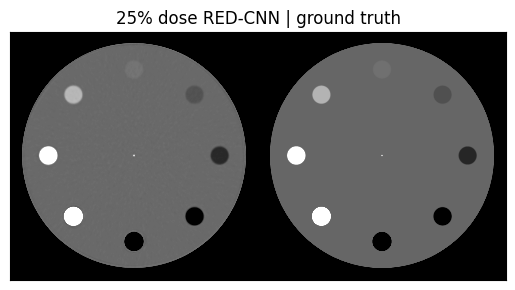

In [7]:
from results_utils import browse_studies, study_viewer
browse_studies(meta, phantom='CTP404', diameter=35, fov=38.5, dose=25, recon='RED-CNN')

In [6]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404',), value='CTP404'), Dropdown(descripti…